# Algorithms lab 4

The following command can be used for required dependency installation:

```shell
pip install networkx matplotlib
```

### Following cell defines useful drawing functions

In [539]:
from math import sqrt
from typing import Tuple, Optional

from networkx import Graph, draw_networkx, draw_networkx_edge_labels, draw_networkx_labels, draw_networkx_edges


def _draw_graph_labels(graph: Graph, position_label: str = "pos", weight_label: str = "weight", multiplicaton_label: Optional[str] = "size", ax = None):
    size = graph.graph.get(multiplicaton_label, 1)
    weights = {(s, e): f"{size * v:.2f}" for s, e, v in graph.edges.data(weight_label)}
    draw_networkx_edge_labels(graph, graph.nodes.data(position_label), weights, ax=ax)


def _draw_graph_edges(graph: Graph, color: str, width: float = 2.0, position_label: str = "pos", node_label: Optional[str] = "order", ax = None):
    draw_networkx_edges(graph, graph.nodes.data(position_label), width=width, edge_color=color, ax=ax)
    draw_networkx_labels(graph, graph.nodes.data(position_label), dict(graph.nodes.data(node_label, default=' ')), ax=ax)


def draw_single_graph(graph: Graph, position_label: str = "pos", weight_label: str = "weight", multiplicaton_label: Optional[str] = "size", ax = None):
    draw_networkx(graph, graph.nodes.data(position_label), with_labels=False, ax=ax)
    _draw_graph_labels(graph, position_label, weight_label, multiplicaton_label, ax=ax)


def draw_combined_graphs(root: Graph, *graphs: Tuple[Graph, str, float], position_label: str = "pos", weight_label: str = "weight", node_label: Optional[str] = "order", multiplicaton_label: Optional[str] = "size", ax = None):
    draw_networkx(root, root.nodes.data(position_label), with_labels=False, ax=ax)
    for subgraph, color, width in graphs:
        _draw_graph_edges(subgraph, color, width, position_label, node_label, ax=ax)
    _draw_graph_labels(root, position_label, weight_label, multiplicaton_label, ax=ax)

### Graph generation

Use the following cell to generate and visualize the graph.
The two defined constants (`NODES_NUMBER` and `GRAPH_MULTIPLY`) specify graph node number and graph size.

> Graph is random, so feel free to re-run this cell if you don't like it.
> You can also modify the constants.

We are looking for the minimal hamiltonian path searching algorithm.
Minimal hamiltonian path has lenght `H`.

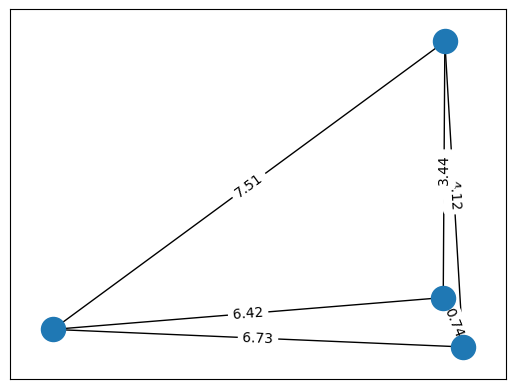

In [540]:
import matplotlib.pyplot as plt

from networkx import Graph, random_geometric_graph

NODES_NUMBER = 4
GRAPH_MULTIPLY = 10


def create_random_graph() -> Graph:
    graph = random_geometric_graph(NODES_NUMBER, 10)
    graph.graph.update({"size": GRAPH_MULTIPLY})
    for start, end in graph.edges:
        start_x, start_y = graph.nodes[start]["pos"]
        end_x, end_y = graph.nodes[end]["pos"]
        weight = sqrt((start_x - end_x) ** 2 + (start_y - end_y) ** 2)
        graph.edges[start, end].update({"weight": weight})
    return graph


graph = create_random_graph()
draw_single_graph(graph)
plt.draw()

### Greedy algorithm

Starts from a random point, always chooses the closest by euclidiean distance point.

We can not provide any guarantees about its performance, it is random.

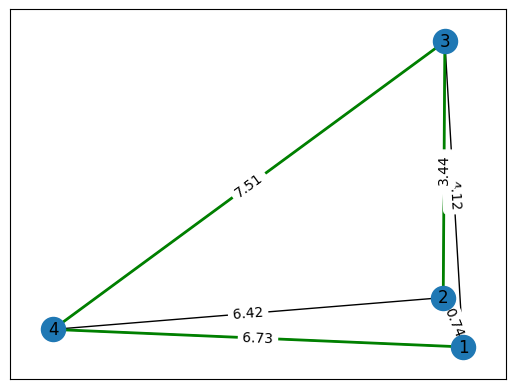

In [541]:
from random import random

from networkx import Graph


def greedy_algorithm(graph: Graph) -> Graph:
    cov = Graph()

    current_node = int(random() * NODES_NUMBER)
    cov.add_node(current_node, **graph.nodes[current_node], order=1)
    start_node = current_node

    while len(cov.nodes) < len(graph.nodes):
        available_edges = [(s, e) for s, e in graph.edges(current_node) if e not in cov.nodes or e not in cov.nodes]
        (start, end), _ = sorted({edge: graph.edges[edge]["weight"] for edge in available_edges}.items(), key=lambda w: w[1])[0]
        next_node = start if start != current_node else end
        cov.add_node(next_node, **graph.nodes[next_node], order=1+len(cov.nodes))
        cov.add_edge(start, end, **graph.edges[(start, end)])
        current_node = next_node

    cov.add_edge(current_node, start_node)
    return cov


greedy_path = greedy_algorithm(graph)
draw_combined_graphs(graph, (greedy_path, 'g', 2.0))
plt.draw()

### Minimal spanning tree

Has total length `N`.
We know that since it is a **tree** it has no cycles.
In order to transform it to a hamiltonian cycle (not necesserily minimal), we would have to add an edge to it.
So, `N` < (some hamiltonian cycle length) < `H`.

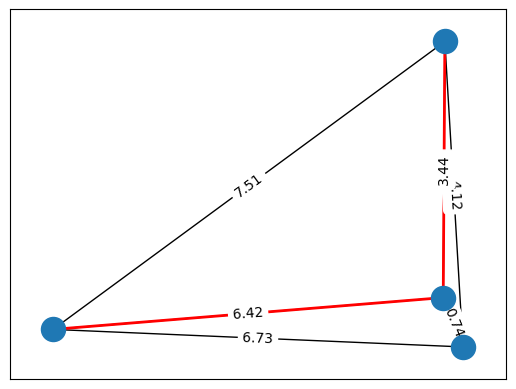

In [542]:
import matplotlib.pyplot as plt

from networkx import minimum_spanning_tree


minimum_spanning = minimum_spanning_tree(graph, algorithm="prim")
draw_combined_graphs(graph, (minimum_spanning, 'r', 2.0))
plt.draw()

### Depth search algorithm

We use it to give order to nodes.
Depth-search route across minimal spanning tree will have length `D` = `2 * N`.

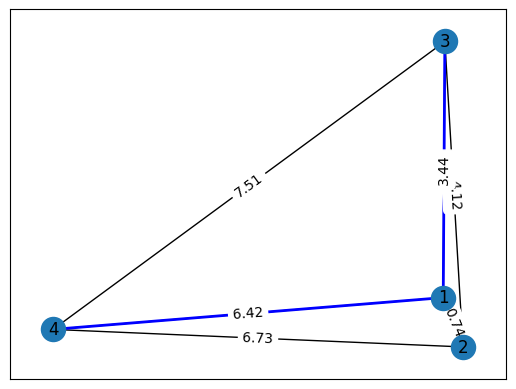

In [543]:
from typing import Literal

import matplotlib.pyplot as plt


def depth_search(graph: Graph, branch_first: Literal["ascend", "descend"] = "ascend", item_first: Literal["parent", "child"] = "parent") -> Graph:
    cov = Graph()

    def search(node: int, iteration: int = 1) -> int:
        cov.add_node(node, **graph.nodes[node], order=iteration)
        for neighbor in sorted(graph.neighbors(node), reverse=branch_first == "descend"):
            if neighbor not in cov.nodes:
                if item_first == "parent":
                    iteration = search(neighbor, iteration + 1)
                else:
                    iteration = search(neighbor, iteration) + 1
                cov.add_edge(node, neighbor, **graph.edges[(node, neighbor)])
        if item_first == "child":
            cov.nodes[node].update(order=iteration)
        return iteration

    current_node = int(random() * NODES_NUMBER)
    search(current_node)
    return cov


depth_search_tree = depth_search(minimum_spanning)
draw_combined_graphs(graph, (depth_search_tree, 'b', 2.0))
plt.draw()

### Optimal algorithm

It uses the order, provided by depth-search algorithm and "cuts corners".
Path through cut corner will always be shorter than path through uncut corner.
So, optimal algorithm resulting path length would be:
`P` < `D` = `2 * N` < `2 * H`.
This proves that optimal algorithm is at most two times slower than optimal.

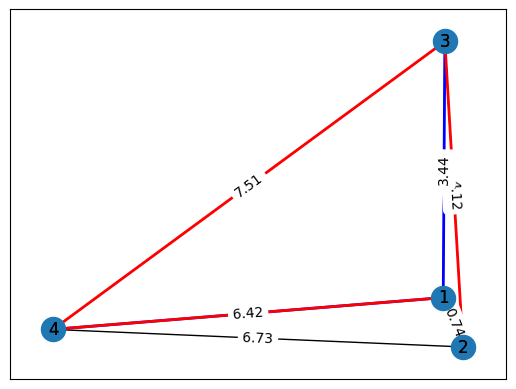

In [544]:
import matplotlib.pyplot as plt

from networkx import Graph


def optimal_path(source: Graph, search: Graph) -> Graph:
    cov = Graph()
    node_order = dict(search.nodes.data("order"))

    current_node = [id for id, ord in node_order.items() if ord == 1][0]
    cov.add_node(current_node, **search.nodes[current_node])
    start_node = current_node

    for i in range(2, NODES_NUMBER + 1):
        next_node = [id for id, ord in node_order.items() if ord == i][0]
        cov.add_node(next_node, **search.nodes[next_node])
        cov.add_edge(current_node, next_node, **source.edges[(current_node, next_node)])
        current_node = next_node

    cov.add_edge(current_node, start_node)
    return cov


optimal_path_tree = optimal_path(graph, depth_search_tree)
draw_combined_graphs(graph, (depth_search_tree, 'b', 2.0), (optimal_path_tree, 'r', 2.0))
plt.draw()

### Special case

Consider this graph.
If node ordering is chosen incorrectly, the result can become significantly further from optimal.
This problem can be solved by testing different depth-search tree node orderings.

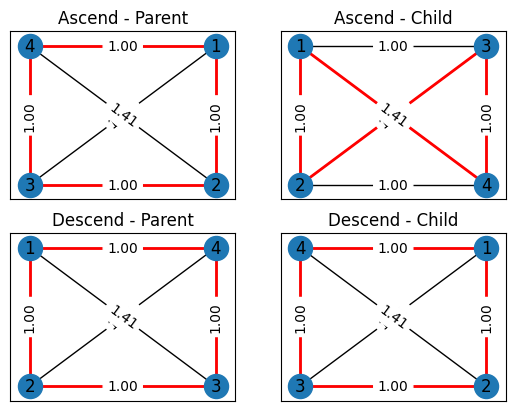

In [545]:
from math import sqrt

from networkx import minimum_spanning_tree

import matplotlib.pyplot as plt


def square_graph() -> Graph:
    graph = Graph()
    graph.add_nodes_from([(n, dict(pos=[n % 2, n // 2])) for n in range(4)])
    graph.add_weighted_edges_from([(0, 1, 1), (1, 3, 1), (2, 3, 1), (0, 2, 1)])
    graph.add_weighted_edges_from([(0, 3, sqrt(2)), (1, 2, sqrt(2))])
    return graph


def draw_square_option(square: Graph, branch_first: Literal["ascend", "descend"], item_first: Literal["parent", "child"], name: str, ax):
    ax.set_title(name)
    minimum_spanning = minimum_spanning_tree(square, algorithm="prim")
    depth_search_tree = depth_search(minimum_spanning, branch_first, item_first)
    optimal_path_tree = optimal_path(square, depth_search_tree)
    draw_combined_graphs(square, (optimal_path_tree, 'r', 2.0), ax=ax)


fig, ax = plt.subplots(2, 2)
square = square_graph()
draw_square_option(square, "ascend", "parent", "Ascend - Parent", ax[0][0])
draw_square_option(square, "ascend", "child", "Ascend - Child", ax[0][1])
draw_square_option(square, "descend", "parent", "Descend - Parent", ax[1][0])
draw_square_option(square, "descend", "child", "Descend - Child", ax[1][1])
plt.draw()